# [순환신경망 실습: 시계열 데이터 모델링]

### 1. 모듈 불러오기

In [34]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim

import matplotlib.pyplot as plt
# Random seed to make results deterministic and reproducible
torch.manual_seed(190731)

#### 정규화 함수

In [7]:
# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

### 2. 데이터 불러오기
##### http://finance.yahoo.com/quote/GOOG/history?ltr=1

In [59]:
data = pd.read_csv("Data/data-02-stock_daily.csv")

In [60]:
data.head()

,Open,High,Low,Volume,Close
0,828.659973,833.450012,828.349976,1247700,831.659973
1,823.020020,828.070007,821.655029,1597800,828.070007
2,819.929993,824.400024,818.979980,1281700,824.159973
3,819.359985,823.000000,818.469971,1304000,818.979980
4,819.000000,823.000000,816.000000,1053600,820.450012


In [61]:
data_rvs = data[::-1]  # reverse order

In [62]:
data_rvs.head()

,Open,High,Low,Volume,Close
731,568.002570,568.002570,552.922516,13100,558.462551
730,561.202549,566.432590,558.672539,41200,559.992565
729,566.892592,567.002574,556.932537,10800,556.972503
728,558.712504,568.452595,558.712504,7900,567.162558
727,599.992707,604.832763,562.192568,147100,567.002574


In [72]:

# split train-test set
train_size = int(len(data_rvs) * 0.7)
train_set = data_rvs[0:train_size]
test_set = data_rvs[train_size - seq_length:]

In [73]:
# scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

In [76]:
train_set.head()

,Open,High,Low,Volume,Close
731,0.253065,0.245071,0.233983,0.000466,0.232040
730,0.229604,0.239729,0.254568,0.002985,0.237426
729,0.249236,0.241668,0.248338,0.000260,0.226794
728,0.221013,0.246602,0.254711,0.000000,0.262668
727,0.363434,0.370390,0.267169,0.012476,0.262105


### 3. 데이터 전처리: sequence 길이에 맞게  RNN Input 데이터 만들기

In [105]:
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series.iloc[i:i + seq_length, :]
        _y = time_series.iloc[i + seq_length, [-1]]  # Next close price
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

#### hyperparameters
- seq_length: 시퀀스 길이
- data_dim: 변수 개수
- hidden_dim: hidden state vector 차원(=특징을 얼마나 추출하여 학습할 것인지)
- output_dim: 학습 반복 회수
- learning_rate: 학습률
- iterations: 학습 반복 회수

## ++++ hidden state vector 모양 추가할 것.

In [106]:
seq_length = 7 
data_dim = 5 
hidden_dim = 10
output_dim = 1 
learning_rate = 0.01
iterations = 500 

In [103]:
# make train-test dataset to input
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)


         Open      High       Low    Volume     Close
731  0.253065  0.245071  0.233983  0.000466  0.232040
730  0.229604  0.239729  0.254568  0.002985  0.237426
729  0.249236  0.241668  0.248338  0.000260  0.226794
728  0.221013  0.246602  0.254711  0.000000  0.262668
727  0.363434  0.370390  0.267169  0.012476  0.262105
726  0.259448  0.310674  0.274114  0.456323  0.271751
725  0.276008  0.278315  0.198470  0.570171  0.178105 -> Close    0.160537
Name: 724, dtype: float64
         Open      High       Low    Volume     Close
730  0.229604  0.239729  0.254568  0.002985  0.237426
729  0.249236  0.241668  0.248338  0.000260  0.226794
728  0.221013  0.246602  0.254711  0.000000  0.262668
727  0.363434  0.370390  0.267169  0.012476  0.262105
726  0.259448  0.310674  0.274114  0.456323  0.271751
725  0.276008  0.278315  0.198470  0.570171  0.178105
724  0.159015  0.178652  0.141729  0.393807  0.160537 -> Close    0.219506
Name: 723, dtype: float64
         Open      High       Low    Volum

708  0.113681  0.108966  0.125154  0.156243  0.120086 -> Close    0.136597
Name: 707, dtype: float64
         Open      High       Low    Volume     Close
713  0.135037  0.128939  0.138507  0.183239  0.121072
712  0.122203  0.121385  0.123722  0.168074  0.114805
711  0.096120  0.097737  0.099736  0.187541  0.083191
710  0.077731  0.076981  0.054558  0.298252  0.086606
709  0.076765  0.113934  0.102958  0.241203  0.123747
708  0.113681  0.108966  0.125154  0.156243  0.120086
707  0.111990  0.125741  0.130022  0.170082  0.136597 -> Close    0.124557
Name: 706, dtype: float64
         Open      High       Low    Volume     Close
712  0.122203  0.121385  0.123722  0.168074  0.114805
711  0.096120  0.097737  0.099736  0.187541  0.083191
710  0.077731  0.076981  0.054558  0.298252  0.086606
709  0.076765  0.113934  0.102958  0.241203  0.123747
708  0.113681  0.108966  0.125154  0.156243  0.120086
707  0.111990  0.125741  0.130022  0.170082  0.136597
706  0.134934  0.129382  0.136216  0.15063

691  0.181510  0.196209  0.200976  0.172466  0.211761 -> Close    0.258408
Name: 690, dtype: float64
         Open      High       Low    Volume     Close
696  0.092256  0.087870  0.099808  0.132410  0.098857
695  0.086425  0.115022  0.107480  0.113812  0.127831
694  0.121064  0.136970  0.138686  0.159254  0.131035
693  0.131966  0.147017  0.158769  0.106507  0.163318
692  0.160361  0.175657  0.190523  0.144116  0.184864
691  0.181510  0.196209  0.200976  0.172466  0.211761
690  0.211664  0.238266  0.239102  0.187882  0.258408 -> Close    0.243376
Name: 689, dtype: float64
         Open      High       Low    Volume     Close
695  0.086425  0.115022  0.107480  0.113812  0.127831
694  0.121064  0.136970  0.138686  0.159254  0.131035
693  0.131966  0.147017  0.158769  0.106507  0.163318
692  0.160361  0.175657  0.190523  0.144116  0.184864
691  0.181510  0.196209  0.200976  0.172466  0.211761
690  0.211664  0.238266  0.239102  0.187882  0.258408
689  0.241231  0.244527  0.262909  0.14736

674  0.173230  0.195937  0.202050  0.155400  0.214120 -> Close    0.219506
Name: 673, dtype: float64
         Open      High       Low    Volume     Close
679  0.218564  0.217442  0.241501  0.097894  0.233377
678  0.216149  0.211011  0.218017  0.130008  0.207008
677  0.198760  0.191650  0.207635  0.108685  0.208452
676  0.188410  0.182531  0.193172  0.151887  0.182118
675  0.170952  0.167899  0.185332  0.128762  0.177647
674  0.173230  0.195937  0.202050  0.155400  0.214120
673  0.205592  0.200837  0.218196  0.219494  0.219506 -> Close    0.224646
Name: 672, dtype: float64
         Open      High       Low    Volume     Close
678  0.216149  0.211011  0.218017  0.130008  0.207008
677  0.198760  0.191650  0.207635  0.108685  0.208452
676  0.188410  0.182531  0.193172  0.151887  0.182118
675  0.170952  0.167899  0.185332  0.128762  0.177647
674  0.173230  0.195937  0.202050  0.155400  0.214120
673  0.205592  0.200837  0.218196  0.219494  0.219506
672  0.214596  0.209616  0.224933  0.40337

657  0.303436  0.303630  0.323875  0.165466  0.325017 -> Close    0.3247
Name: 656, dtype: float64
         Open      High       Low    Volume     Close
662  0.307439  0.307781  0.329459  0.094712  0.315793
661  0.286393  0.284297  0.281292  0.170440  0.276504
660  0.265416  0.274742  0.292894  0.099382  0.294072
659  0.245854  0.274300  0.277264  0.120893  0.276539
658  0.266555  0.288795  0.300211  0.144645  0.304985
657  0.303436  0.303630  0.323875  0.165466  0.325017
656  0.314270  0.305655  0.318612  0.144761  0.324700 -> Close    0.317237
Name: 655, dtype: float64
         Open      High       Low    Volume     Close
661  0.286393  0.284297  0.281292  0.170440  0.276504
660  0.265416  0.274742  0.292894  0.099382  0.294072
659  0.245854  0.274300  0.277264  0.120893  0.276539
658  0.266555  0.288795  0.300211  0.144645  0.304985
657  0.303436  0.303630  0.323875  0.165466  0.325017
656  0.314270  0.305655  0.318612  0.144761  0.324700
655  0.322067  0.314484  0.338803  0.124514 

640  0.231605  0.254258  0.259329  0.118885  0.259901 -> Close    0.24929
Name: 639, dtype: float64
         Open      High       Low    Volume     Close
645  0.317064  0.318228  0.345247  0.090392  0.333995
644  0.296536  0.298322  0.295128  0.187757  0.278300
643  0.261345  0.272156  0.269531  0.174536  0.258831
642  0.256653  0.270080  0.274006  0.127221  0.283756
641  0.260138  0.258613  0.268672  0.138326  0.255310
640  0.231605  0.254258  0.259329  0.118885  0.259901
639  0.253065  0.251502  0.263267  0.098862  0.249290 -> Close    0.268336
Name: 638, dtype: float64
         Open      High       Low    Volume     Close
644  0.296536  0.298322  0.295128  0.187757  0.278300
643  0.261345  0.272156  0.269531  0.174536  0.258831
642  0.256653  0.270080  0.274006  0.127221  0.283756
641  0.260138  0.258613  0.268672  0.138326  0.255310
640  0.231605  0.254258  0.259329  0.118885  0.259901
639  0.253065  0.251502  0.263267  0.098862  0.249290
638  0.237747  0.252727  0.260582  0.133262

623  0.264554  0.258818  0.284635  0.096424  0.278300 -> Close    0.298472
Name: 622, dtype: float64
         Open      High       Low    Volume     Close
628  0.306852  0.303719  0.333218  0.070010  0.316885
627  0.310751  0.302916  0.327347  0.121314  0.308576
626  0.298813  0.292027  0.318684  0.146249  0.300338
625  0.285048  0.280765  0.295497  0.151958  0.276187
624  0.258447  0.262935  0.284746  0.115174  0.269850
623  0.264554  0.258818  0.284635  0.096424  0.278300
622  0.266348  0.278519  0.299388  0.140764  0.298472 -> Close    0.30062
Name: 621, dtype: float64
         Open      High       Low    Volume     Close
627  0.310751  0.302916  0.327347  0.121314  0.308576
626  0.298813  0.292027  0.318684  0.146249  0.300338
625  0.285048  0.280765  0.295497  0.151958  0.276187
624  0.258447  0.262935  0.284746  0.115174  0.269850
623  0.264554  0.258818  0.284635  0.096424  0.278300
622  0.266348  0.278519  0.299388  0.140764  0.298472
621  0.294466  0.296076  0.313027  0.108201

606  0.299503  0.318670  0.332789  0.154181  0.336001 -> Close    0.290481
Name: 605, dtype: float64
         Open      High       Low    Volume     Close
611  0.294501  0.311490  0.326542  0.151017  0.324665
610  0.318617  0.318364  0.348826  0.128762  0.340508
609  0.334142  0.341978  0.364936  0.334203  0.364483
608  0.342147  0.333366  0.343313  0.150722  0.333819
607  0.318100  0.309211  0.334507  0.131173  0.311850
606  0.299503  0.318670  0.332789  0.154181  0.336001
605  0.320514  0.313055  0.310092  0.171910  0.290481 -> Close    0.297663
Name: 604, dtype: float64
         Open      High       Low    Volume     Close
610  0.318617  0.318364  0.348826  0.128762  0.340508
609  0.334142  0.341978  0.364936  0.334203  0.364483
608  0.342147  0.333366  0.343313  0.150722  0.333819
607  0.318100  0.309211  0.334507  0.131173  0.311850
606  0.299503  0.318670  0.332789  0.154181  0.336001
605  0.320514  0.313055  0.310092  0.171910  0.290481
604  0.280873  0.283350  0.311810  0.12868

589  0.112473  0.119106  0.075071  0.495778  0.065553 -> Close    0.099596
Name: 588, dtype: float64
         Open      High       Low    Volume     Close
594  0.217598  0.235305  0.202229  0.275522  0.182857
593  0.173678  0.182122  0.163029  0.230680  0.143145
592  0.152667  0.174262  0.163280  0.198494  0.159798
591  0.125446  0.125298  0.110047  0.332652  0.131950
590  0.084010  0.113832  0.098233  0.331684  0.112517
589  0.112473  0.119106  0.075071  0.495778  0.065553
588  0.051062  0.087733  0.073531  0.233002  0.099596 -> Close    0.119663
Name: 587, dtype: float64
         Open      High       Low    Volume     Close
593  0.173678  0.182122  0.163029  0.230680  0.143145
592  0.152667  0.174262  0.163280  0.198494  0.159798
591  0.125446  0.125298  0.110047  0.332652  0.131950
590  0.084010  0.113832  0.098233  0.331684  0.112517
589  0.112473  0.119106  0.075071  0.495778  0.065553
588  0.051062  0.087733  0.073531  0.233002  0.099596
587  0.105366  0.104849  0.112946  0.20868

572  0.185753  0.190425  0.210284  0.085830  0.203277 -> Close    0.192785
Name: 571, dtype: float64
         Open      High       Low    Volume     Close
577  0.201314  0.202538  0.221024  0.110809  0.216725
576  0.214424  0.206962  0.202229  0.181438  0.187892
575  0.175438  0.173224  0.191203  0.118786  0.174232
574  0.177887  0.170928  0.182969  0.145720  0.170606
573  0.161499  0.182428  0.191382  0.100986  0.193419
572  0.185753  0.190425  0.210284  0.085830  0.203277
571  0.192309  0.185389  0.206239  0.100538  0.192785 -> Close    0.185991
Name: 570, dtype: float64
         Open      High       Low    Volume     Close
576  0.214424  0.206962  0.202229  0.181438  0.187892
575  0.175438  0.173224  0.191203  0.118786  0.174232
574  0.177887  0.170928  0.182969  0.145720  0.170606
573  0.161499  0.182428  0.191382  0.100986  0.193419
572  0.185753  0.190425  0.210284  0.085830  0.203277
571  0.192309  0.185389  0.206239  0.100538  0.192785
570  0.190273  0.183143  0.200189  0.11933

555  0.125411  0.125605  0.131454  0.229246  0.115157 -> Close    0.121212
Name: 554, dtype: float64
         Open      High       Low    Volume     Close
560  0.158601  0.156603  0.175559  0.102214  0.173493
559  0.152667  0.154595  0.158590  0.188886  0.145223
558  0.134071  0.134486  0.151215  0.136121  0.145047
557  0.126929  0.136173  0.149282  0.113830  0.136492
556  0.125963  0.140746  0.146884  0.124066  0.157580
555  0.125411  0.125605  0.131454  0.229246  0.115157
554  0.112059  0.119174  0.129700  0.208067  0.121212 -> Close    0.143709
Name: 553, dtype: float64
         Open      High       Low    Volume     Close
559  0.152667  0.154595  0.158590  0.188886  0.145223
558  0.134071  0.134486  0.151215  0.136121  0.145047
557  0.126929  0.136173  0.149282  0.113830  0.136492
556  0.125963  0.140746  0.146884  0.124066  0.157580
555  0.125411  0.125605  0.131454  0.229246  0.115157
554  0.112059  0.119174  0.129700  0.208067  0.121212
553  0.094843  0.130028  0.117922  0.16701

538  0.126274  0.124618  0.136896  0.121923  0.119171 -> Close    0.113573
Name: 537, dtype: float64
         Open      High       Low    Volume     Close
543  0.111611  0.131287  0.138650  0.196262  0.133922
542  0.123721  0.121756  0.141263  0.062562  0.127514
541  0.117718  0.130232  0.142301  0.092552  0.146032
540  0.129517  0.134417  0.151971  0.203513  0.133006
539  0.115371  0.119684  0.141657  0.077826  0.133323
538  0.126274  0.124618  0.136896  0.121923  0.119171
537  0.118546  0.120092  0.130810  0.129031  0.113573 -> Close    0.075058
Name: 536, dtype: float64
         Open      High       Low    Volume     Close
542  0.123721  0.121756  0.141263  0.062562  0.127514
541  0.117718  0.130232  0.142301  0.092552  0.146032
540  0.129517  0.134417  0.151971  0.203513  0.133006
539  0.115371  0.119684  0.141657  0.077826  0.133323
538  0.126274  0.124618  0.136896  0.121923  0.119171
537  0.118546  0.120092  0.130810  0.129031  0.113573
536  0.098707  0.096478  0.091288  0.18391

Name: 520, dtype: float64
         Open      High       Low    Volume     Close
526  0.056409  0.056225  0.066071  0.199346  0.050520
525  0.043471  0.079295  0.066730  0.202635  0.089739
524  0.092566  0.137310  0.115058  0.239222  0.147300
523  0.141247  0.157181  0.162671  0.203800  0.166874
522  0.151391  0.146395  0.150750  0.137653  0.150187
521  0.121858  0.118153  0.109653  0.169947  0.091816
520  0.097051  0.091919  0.080333  0.150211  0.061434 -> Close    0.063757
Name: 519, dtype: float64
         Open      High       Low    Volume     Close
525  0.043471  0.079295  0.066730  0.202635  0.089739
524  0.092566  0.137310  0.115058  0.239222  0.147300
523  0.141247  0.157181  0.162671  0.203800  0.166874
522  0.151391  0.146395  0.150750  0.137653  0.150187
521  0.121858  0.118153  0.109653  0.169947  0.091816
520  0.097051  0.091919  0.080333  0.150211  0.061434
519  0.056409  0.051427  0.048830  0.374509  0.063757 -> Close    0.147758
Name: 518, dtype: float64
         Open   

503  0.142834  0.137681  0.149819  0.129954  0.138569 -> Close    0.153285
Name: 502, dtype: float64
         Open      High       Low    Volume     Close
508  0.168020  0.183517  0.198936  0.169615  0.198770
507  0.180026  0.183824  0.191633  0.144205  0.177048
506  0.161292  0.168478  0.178817  0.129524  0.165994
505  0.149700  0.160380  0.180606  0.087945  0.177154
504  0.167261  0.162557  0.172695  0.128744  0.163354
503  0.142834  0.137681  0.149819  0.129954  0.138569
502  0.121961  0.138875  0.145667  0.089370  0.153285 -> Close    0.180675
Name: 501, dtype: float64
         Open      High       Low    Volume     Close
507  0.180026  0.183824  0.191633  0.144205  0.177048
506  0.161292  0.168478  0.178817  0.129524  0.165994
505  0.149700  0.160380  0.180606  0.087945  0.177154
504  0.167261  0.162557  0.172695  0.128744  0.163354
503  0.142834  0.137681  0.149819  0.129954  0.138569
502  0.121961  0.138875  0.145667  0.089370  0.153285
501  0.142317  0.170962  0.171424  0.16294

486  0.199588  0.217101  0.212790  0.190607  0.235701 -> Close    0.230385
Name: 485, dtype: float64
         Open      High       Low    Volume     Close
491  0.208697  0.211521  0.225964  0.162481  0.206410
490  0.203073  0.205498  0.225176  0.123842  0.221654
489  0.203038  0.212406  0.202838  0.151976  0.192821
488  0.194241  0.207132  0.209210  0.146366  0.218133
487  0.196863  0.196754  0.216370  0.161119  0.205213
486  0.199588  0.217101  0.212790  0.190607  0.235701
485  0.223360  0.220572  0.245528  0.106597  0.230385 -> Close    0.238729
Name: 484, dtype: float64
         Open      High       Low    Volume     Close
490  0.203073  0.205498  0.225176  0.123842  0.221654
489  0.203038  0.212406  0.202838  0.151976  0.192821
488  0.194241  0.207132  0.209210  0.146366  0.218133
487  0.196863  0.196754  0.216370  0.161119  0.205213
486  0.199588  0.217101  0.212790  0.190607  0.235701
485  0.223360  0.220572  0.245528  0.106597  0.230385
484  0.231157  0.223702  0.255928  0.23383

469  0.150977  0.163612  0.178101  0.146760  0.164128 -> Close    0.133218
Name: 468, dtype: float64
         Open      High       Low    Volume     Close
474  0.129620  0.144387  0.150392  0.117998  0.155661
473  0.149838  0.158950  0.173411  0.116062  0.156559
472  0.150873  0.162898  0.181931  0.104921  0.172718
471  0.160016  0.156432  0.171585  0.138917  0.169796
470  0.164363  0.157589  0.178101  0.125616  0.167085
469  0.150977  0.163612  0.178101  0.146760  0.164128
468  0.143524  0.141529  0.145101  0.232697  0.133218 -> Close    0.140752
Name: 467, dtype: float64
         Open      High       Low    Volume     Close
473  0.149838  0.158950  0.173411  0.116062  0.156559
472  0.150873  0.162898  0.181931  0.104921  0.172718
471  0.160016  0.156432  0.171585  0.138917  0.169796
470  0.164363  0.157589  0.178101  0.125616  0.167085
469  0.150977  0.163612  0.178101  0.146760  0.164128
468  0.143524  0.141529  0.145101  0.232697  0.133218
467  0.117476  0.131866  0.127660  0.20712

452  0.126231  0.123861  0.120008  0.139742  0.111487 -> Close    0.134301
Name: 451, dtype: float64
         Open      High       Low    Volume     Close
457  0.192576  0.196337  0.212441  0.151555  0.199008
456  0.183606  0.179018  0.170001  0.185919  0.157677
455  0.151037  0.148224  0.159441  0.157775  0.159648
454  0.151382  0.163638  0.170037  0.116528  0.169788
453  0.150278  0.148904  0.153323  0.123259  0.134653
452  0.126231  0.123861  0.120008  0.139742  0.111487
451  0.101218  0.127536  0.122389  0.137887  0.134301 -> Close    0.160775
Name: 450, dtype: float64
         Open      High       Low    Volume     Close
456  0.183606  0.179018  0.170001  0.185919  0.157677
455  0.151037  0.148224  0.159441  0.157775  0.159648
454  0.151382  0.163638  0.170037  0.116528  0.169788
453  0.150278  0.148904  0.153323  0.123259  0.134653
452  0.126231  0.123861  0.120008  0.139742  0.111487
451  0.101218  0.127536  0.122389  0.137887  0.134301
450  0.144896  0.153702  0.134023  0.13621

435  0.145379  0.138867  0.151064  0.169974  0.145883 -> Close    0.164155
Name: 434, dtype: float64
         Open      High       Low    Volume     Close
440  0.156971  0.164046  0.185968  0.104715  0.167429
439  0.149968  0.146386  0.151493  0.214986  0.140004
438  0.131613  0.151660  0.158045  0.135977  0.166302
437  0.149588  0.151865  0.174297  0.091593  0.166267
436  0.147380  0.145127  0.157114  0.232096  0.139264
435  0.145379  0.138867  0.151064  0.169974  0.145883
434  0.132062  0.159997  0.156684  0.173084  0.164155 -> Close    0.168133
Name: 433, dtype: float64
         Open      High       Low    Volume     Close
439  0.149968  0.146386  0.151493  0.214986  0.140004
438  0.131613  0.151660  0.158045  0.135977  0.166302
437  0.149588  0.151865  0.174297  0.091593  0.166267
436  0.147380  0.145127  0.157114  0.232096  0.139264
435  0.145379  0.138867  0.151064  0.169974  0.145883
434  0.132062  0.159997  0.156684  0.173084  0.164155
433  0.156143  0.161698  0.177376  0.15296

418  0.156454  0.149789  0.172185  0.114610  0.159437 -> Close    0.150248
Name: 417, dtype: float64
         Open      High       Low    Volume     Close
423  0.119779  0.119097  0.134381  0.115291  0.129231
422  0.125403  0.143494  0.154751  0.163592  0.155529
421  0.146828  0.143834  0.162698  0.169006  0.155389
420  0.155039  0.162515  0.178880  0.111356  0.160669
419  0.155212  0.154890  0.170717  0.106624  0.168731
418  0.156454  0.149789  0.172185  0.114610  0.159437
417  0.152555  0.152851  0.170646  0.119010  0.150248 -> Close    0.137786
Name: 416, dtype: float64
         Open      High       Low    Volume     Close
422  0.125403  0.143494  0.154751  0.163592  0.155529
421  0.146828  0.143834  0.162698  0.169006  0.155389
420  0.155039  0.162515  0.178880  0.111356  0.160669
419  0.155212  0.154890  0.170717  0.106624  0.168731
418  0.156454  0.149789  0.172185  0.114610  0.159437
417  0.152555  0.152851  0.170646  0.119010  0.150248
416  0.147001  0.142167  0.156756  0.18833

401  0.567842  0.588318  0.592286  0.524603  0.600138 -> Close    0.597603
Name: 400, dtype: float64
         Open      High       Low    Volume     Close
406  0.131889  0.173982  0.160515  0.197060  0.190101
405  0.179776  0.237743  0.211743  0.290060  0.241325
404  0.225904  0.239968  0.247828  0.159245  0.238227
403  0.243120  0.288207  0.277219  0.426674  0.307335
402  0.532513  0.607332  0.563611  1.000000  0.635026
401  0.567842  0.588318  0.592286  0.524603  0.600138
400  0.553938  0.602337  0.596904  0.301990  0.597603 -> Close    0.596899
Name: 399, dtype: float64
         Open      High       Low    Volume     Close
405  0.179776  0.237743  0.211743  0.290060  0.241325
404  0.225904  0.239968  0.247828  0.159245  0.238227
403  0.243120  0.288207  0.277219  0.426674  0.307335
402  0.532513  0.607332  0.563611  1.000000  0.635026
401  0.567842  0.588318  0.592286  0.524603  0.600138
400  0.553938  0.602337  0.596904  0.301990  0.597603
399  0.573535  0.621527  0.613729  0.35147

384  0.581090  0.575116  0.589708  0.262508  0.587957 -> Close    0.577008
Name: 383, dtype: float64
         Open      High       Low    Volume     Close
389  0.481900  0.516795  0.521225  0.208515  0.532403
388  0.518713  0.508353  0.517967  0.140244  0.528530
387  0.502256  0.499169  0.508874  0.125123  0.502548
386  0.499668  0.501755  0.514384  0.161450  0.497021
385  0.602205  0.608802  0.596796  0.450058  0.592252
384  0.581090  0.575116  0.589708  0.262508  0.587957
383  0.568125  0.573414  0.587456  0.161585  0.577008 -> Close    0.579367
Name: 382, dtype: float64
         Open      High       Low    Volume     Close
388  0.518713  0.508353  0.517967  0.140244  0.528530
387  0.502256  0.499169  0.508874  0.125123  0.502548
386  0.499668  0.501755  0.514384  0.161450  0.497021
385  0.602205  0.608802  0.596796  0.450058  0.592252
384  0.581090  0.575116  0.589708  0.262508  0.587957
383  0.568125  0.573414  0.587456  0.161585  0.577008
382  0.553248  0.557609  0.591033  0.09538

367  0.363459  0.365753  0.385511  0.186529  0.380738 -> Close    0.429885
Name: 366, dtype: float64
         Open      High       Low    Volume     Close
372  0.476691  0.479434  0.490438  0.176642  0.485227
371  0.458474  0.475759  0.465808  0.194389  0.442523
370  0.371601  0.397703  0.381394  0.331111  0.370493
369  0.382745  0.402739  0.401477  0.230143  0.428758
368  0.422110  0.421011  0.412614  0.157005  0.400277
367  0.363459  0.365753  0.385511  0.186529  0.380738
366  0.406550  0.409442  0.417265  0.203603  0.429885 -> Close    0.423055
Name: 365, dtype: float64
         Open      High       Low    Volume     Close
371  0.458474  0.475759  0.465808  0.194389  0.442523
370  0.371601  0.397703  0.381394  0.331111  0.370493
369  0.382745  0.402739  0.401477  0.230143  0.428758
368  0.422110  0.421011  0.412614  0.157005  0.400277
367  0.363459  0.365753  0.385511  0.186529  0.380738
366  0.406550  0.409442  0.417265  0.203603  0.429885
365  0.436670  0.444183  0.436882  0.15185

350  0.374775  0.383753  0.405129  0.215605  0.407916 -> Close    0.41802
Name: 349, dtype: float64
         Open      High       Low    Volume     Close
355  0.439533  0.452383  0.474113  0.131128  0.456993
354  0.420868  0.446905  0.446906  0.200072  0.469103
353  0.466168  0.455242  0.441894  0.194147  0.420414
352  0.399133  0.403641  0.364497  0.279627  0.360284
351  0.354075  0.370959  0.367504  0.206292  0.360565
350  0.374775  0.383753  0.405129  0.215605  0.407916
349  0.392336  0.395084  0.401978  0.166685  0.418020 -> Close    0.473011
Name: 348, dtype: float64
         Open      High       Low    Volume     Close
354  0.420868  0.446905  0.446906  0.200072  0.469103
353  0.466168  0.455242  0.441894  0.194147  0.420414
352  0.399133  0.403641  0.364497  0.279627  0.360284
351  0.354075  0.370959  0.367504  0.206292  0.360565
350  0.374775  0.383753  0.405129  0.215605  0.407916
349  0.392336  0.395084  0.401978  0.166685  0.418020
348  0.388300  0.446973  0.413721  0.239930

333  0.803345  0.796286  0.765875  0.595680  0.737368 -> Close    0.77532
Name: 332, dtype: float64
         Open      High       Low    Volume     Close
338  0.584644  0.575014  0.607285  0.143695  0.597251
337  0.574535  0.581308  0.615806  0.131702  0.610981
336  0.584402  0.574163  0.560729  0.222470  0.555286
335  0.550281  0.544050  0.551904  0.159828  0.528284
334  0.524578  0.550617  0.560067  0.364175  0.560602
333  0.803345  0.796286  0.765875  0.595680  0.737368
332  0.713815  0.759367  0.765016  0.242780  0.775320 -> Close    0.760216
Name: 331, dtype: float64
         Open      High       Low    Volume     Close
337  0.574535  0.581308  0.615806  0.131702  0.610981
336  0.584402  0.574163  0.560729  0.222470  0.555286
335  0.550281  0.544050  0.551904  0.159828  0.528284
334  0.524578  0.550617  0.560067  0.364175  0.560602
333  0.803345  0.796286  0.765875  0.595680  0.737368
332  0.713815  0.759367  0.765016  0.242780  0.775320
331  0.733929  0.740551  0.776793  0.200583

316  0.809521  0.802563  0.842939  0.134714  0.819397 -> Close    0.871149
Name: 315, dtype: float64
         Open      High       Low    Volume     Close
321  0.792650  0.798293  0.826733  0.143417  0.830029
320  0.820458  0.833714  0.868725  0.121762  0.854954
319  0.815420  0.822826  0.863051  0.163960  0.840273
318  0.809107  0.800199  0.820397  0.185319  0.790176
317  0.762289  0.794550  0.801065  0.170117  0.832282
316  0.809521  0.802563  0.842939  0.134714  0.819397
315  0.803621  0.835109  0.857162  0.150255  0.871149 -> Close    0.865551
Name: 314, dtype: float64
         Open      High       Low    Volume     Close
320  0.820458  0.833714  0.868725  0.121762  0.854954
319  0.815420  0.822826  0.863051  0.163960  0.840273
318  0.809107  0.800199  0.820397  0.185319  0.790176
317  0.762289  0.794550  0.801065  0.170117  0.832282
316  0.809521  0.802563  0.842939  0.134714  0.819397
315  0.803621  0.835109  0.857162  0.150255  0.871149
314  0.842124  0.837117  0.894500  0.11824

299  0.850473  0.849741  0.892066  0.198665  0.867170 -> Close    0.898503
Name: 298, dtype: float64
         Open      High       Low    Volume     Close
304  0.891667  0.927252  0.939500  0.246428  0.965534
303  0.942280  0.928069  0.957721  0.161728  0.953001
302  0.908193  0.914696  0.954535  0.163270  0.949903
301  0.912609  0.912757  0.892965  0.241292  0.912022
300  0.890805  0.884243  0.917412  0.177198  0.904453
299  0.850473  0.849741  0.892066  0.198665  0.867170
298  0.852647  0.860016  0.847031  0.215524  0.898503 -> Close    0.883118
Name: 297, dtype: float64
         Open      High       Low    Volume     Close
303  0.942280  0.928069  0.957721  0.161728  0.953001
302  0.908193  0.914696  0.954535  0.163270  0.949903
301  0.912609  0.912757  0.892965  0.241292  0.912022
300  0.890805  0.884243  0.917412  0.177198  0.904453
299  0.850473  0.849741  0.892066  0.198665  0.867170
298  0.852647  0.860016  0.847031  0.215524  0.898503
297  0.891322  0.891831  0.914476  0.23826

282  0.813040  0.825208  0.828738  0.264928  0.823234 -> Close    0.781269
Name: 281, dtype: float64
         Open      High       Low    Volume     Close
287  0.972744  0.958250  1.000000  0.115210  0.980285
286  0.948249  0.930689  0.969356  0.132805  0.937616
285  0.856821  0.844126  0.872405  0.292632  0.877626
284  0.868724  0.871143  0.898832  0.174133  0.880232
283  0.811970  0.854742  0.864035  0.173801  0.883893
282  0.813040  0.825208  0.828738  0.264928  0.823234
281  0.816973  0.807276  0.807044  0.218966  0.781269 -> Close    0.786761
Name: 280, dtype: float64
         Open      High       Low    Volume     Close
286  0.948249  0.930689  0.969356  0.132805  0.937616
285  0.856821  0.844126  0.872405  0.292632  0.877626
284  0.868724  0.871143  0.898832  0.174133  0.880232
283  0.811970  0.854742  0.864035  0.173801  0.883893
282  0.813040  0.825208  0.828738  0.264928  0.823234
281  0.816973  0.807276  0.807044  0.218966  0.781269
280  0.765774  0.758363  0.773178  0.18667

265  1.000000  1.000000  0.991945  0.568271  0.957930 -> Close    0.825206
Name: 264, dtype: float64
         Open      High       Low    Volume     Close
270  0.756251  0.756407  0.783703  0.118652  0.776235
269  0.755630  0.756254  0.740422  0.195958  0.730292
268  0.785128  0.808841  0.804717  0.239177  0.839323
267  0.817249  0.847291  0.856446  0.310693  0.881534
266  0.882559  0.891082  0.915407  0.459918  0.913395
265  1.000000  1.000000  0.991945  0.568271  0.957930
264  0.950733  0.947702  0.833893  0.552398  0.825206 -> Close    0.758527
Name: 263, dtype: float64
         Open      High       Low    Volume     Close
269  0.755630  0.756254  0.740422  0.195958  0.730292
268  0.785128  0.808841  0.804717  0.239177  0.839323
267  0.817249  0.847291  0.856446  0.310693  0.881534
266  0.882559  0.891082  0.915407  0.459918  0.913395
265  1.000000  1.000000  0.991945  0.568271  0.957930
264  0.950733  0.947702  0.833893  0.552398  0.825206
263  0.787164  0.786078  0.767164  0.46256

248  0.738069  0.739904  0.763584  0.200376  0.748176 -> Close    0.722476
Name: 247, dtype: float64
         Open      High       Low    Volume     Close
253  0.691321  0.704691  0.739205  0.141741  0.733531
252  0.734171  0.739258  0.769491  0.174052  0.753070
251  0.713470  0.722789  0.737522  0.179385  0.715717
250  0.670241  0.694207  0.691699  0.175289  0.728778
249  0.708502  0.714555  0.726800  0.146482  0.750570
248  0.738069  0.739904  0.763584  0.200376  0.748176
247  0.709572  0.731262  0.752200  0.221672  0.722476 -> Close    0.796548
Name: 246, dtype: float64
         Open      High       Low    Volume     Close
252  0.734171  0.739258  0.769491  0.174052  0.753070
251  0.713470  0.722789  0.737522  0.179385  0.715717
250  0.670241  0.694207  0.691699  0.175289  0.728778
249  0.708502  0.714555  0.726800  0.146482  0.750570
248  0.738069  0.739904  0.763584  0.200376  0.748176
247  0.709572  0.731262  0.752200  0.221672  0.722476
246  0.720957  0.758210  0.759682  0.19212

231  0.837708  0.847325  0.894608  0.113095  0.873789 -> Close    0.864319
Name: 230, dtype: float64
         Open      High       Low    Volume     Close
236  0.801344  0.804077  0.849179  0.153545  0.830064
235  0.799446  0.821703  0.848248  0.144887  0.857383
234  0.834223  0.840758  0.889381  0.166075  0.863333
233  0.852888  0.837117  0.874453  0.266452  0.862699
232  0.834396  0.838818  0.880489  0.163897  0.878507
231  0.837708  0.847325  0.894608  0.113095  0.873789
230  0.854613  0.849775  0.889918  0.127651  0.864319 -> Close    0.854602
Name: 229, dtype: float64
         Open      High       Low    Volume     Close
235  0.799446  0.821703  0.848248  0.144887  0.857383
234  0.834223  0.840758  0.889381  0.166075  0.863333
233  0.852888  0.837117  0.874453  0.266452  0.862699
232  0.834396  0.838818  0.880489  0.163897  0.878507
231  0.837708  0.847325  0.894608  0.113095  0.873789
230  0.854613  0.849775  0.889918  0.127651  0.864319
229  0.818905  0.822646  0.871482  0.14224

ValueError: cannot copy sequence with size 7 to array axis with dimension 5

In [104]:
# convert to tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

### 4. RNN 학습 및 평가: 다음 시점의 Close price 예측

In [91]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        #self.rnn = torch.nn.RNN(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        #self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.rnn = torch.nn.GRU(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x


net = Net(data_dim, hidden_dim, output_dim, 1)

In [92]:
# loss & optimizer setting
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [93]:
# start training
for i in range(iterations):

    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i, loss.item())

0 0.15132397413253784
1 0.1030193343758583
2 0.08496348559856415
3 0.08286496996879578
4 0.07937796413898468
5 0.07072090357542038
6 0.059371840208768845
7 0.0483025424182415
8 0.03939182311296463
9 0.0332021564245224
10 0.029222914949059486
11 0.02636663243174553
12 0.023554770275950432
13 0.020164787769317627
14 0.016181407496333122
15 0.012065998278558254
16 0.008469579741358757
17 0.0059199258685112
18 0.004584272857755423
19 0.004196544177830219
20 0.004205529578030109
21 0.004087069537490606
22 0.0036260909400880337
23 0.0029820138588547707
24 0.0025199735537171364
25 0.0025399639271199703
26 0.0030700466595590115
27 0.0038435785099864006
28 0.004473569802939892
29 0.004696309566497803
30 0.004503695294260979
31 0.004091396927833557
32 0.0036964132450520992
33 0.0034496095031499863
34 0.003327996004372835
35 0.003214055672287941
36 0.0030023474246263504
37 0.00267472374252975
38 0.00230267527513206
39 0.001991748111322522
40 0.0018148550298064947
41 0.0017764260992407799
42 0.001

323 0.0013077475596219301
324 0.001307204132899642
325 0.0013066624524071813
326 0.0013061219360679388
327 0.001305583049543202
328 0.0013050456764176488
329 0.0013045097002759576
330 0.0013039752375334501
331 0.0013034422881901264
332 0.001302910503000021
333 0.0013023801147937775
334 0.0013018512399867177
335 0.0013013238785788417
336 0.0013007974484935403
337 0.0013002727646380663
338 0.0012997492449358106
339 0.001299227005802095
340 0.0012987060472369194
341 0.001298186369240284
342 0.0012976679718121886
343 0.001297151087783277
344 0.00129663513507694
345 0.0012961204629391432
346 0.0012956069549545646
347 0.001295094727538526
348 0.001294583547860384
349 0.001294073648750782
350 0.001293565146625042
351 0.0012930574594065547
352 0.0012925509363412857
353 0.001292045577429235
354 0.0012915414990857244
355 0.0012910383520647883
356 0.0012905364856123924
357 0.0012900353176519275
358 0.0012895354302600026
359 0.0012890365906059742
360 0.001288538915105164
361 0.0012880420545116067


### 5. 시각화 

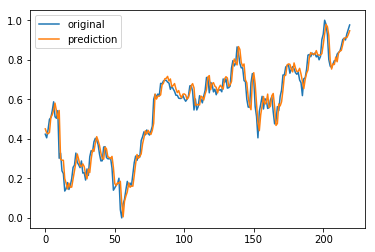

In [94]:
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()